In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
df1 = pd.read_csv("dataset1.csv")
df1.month = pd.to_datetime(df1.month)
df1.set_index("month", inplace=True)
df1.sort_index(inplace=True)

print(df1.info())
df1.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2018-01-31 to 2025-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       96 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB
None


,y
month,
2018-01-31,486.370312
2018-02-28,517.018280
2018-03-31,517.650581
2018-04-30,528.576952
2018-05-31,514.585551


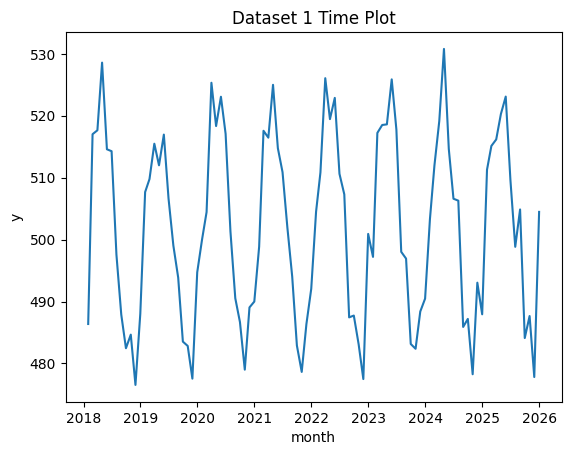

In [80]:
sns.lineplot(df1)
plt.title("Dataset 1 Time Plot")
plt.legend().remove()
plt.ylabel("y");

At first glance, this data heavily relies on seasonality for variation. The magnitude of seasonality remain consistent all throught out so let so we can say that the seasonal component is additive.  

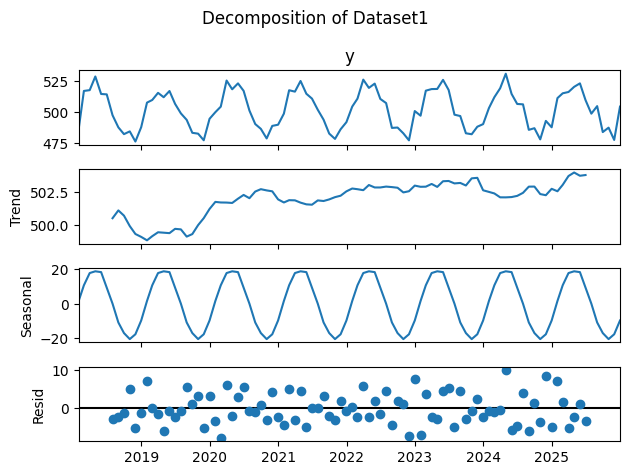

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df1['y'], model="additive", period=12)
fig = result.plot()
fig.suptitle("Decomposition of Dataset1")
plt.tight_layout();

Based on the decomposition plot above:
1. Minimal trend occur: Although there is a slight dip around 2019, on the larger scheme of the things, the trend went from 501 to 503--indicating a minimal trend happening.
2. Seaonal component is apparent. To be specific, yearly seasonality happens, flactuating from -20 to 20, in `Dataset1`, (since what we got is a monthly data, period=12). 
3. The variance is consistent all throughtout.
4. Residual is randomly flactuate around 0 from -10 to 10. There's no obvious pattern in the residuals, suggesting the seasonal decomposition has effectively captured the structured components of your time series.

With all the being said, it goes without saying that the trend/mean remain consistent all throughtout the span of data with the variation mostly determined by seasonality. 

Also, since seasonality exist, `dataset1` is non-stationary.

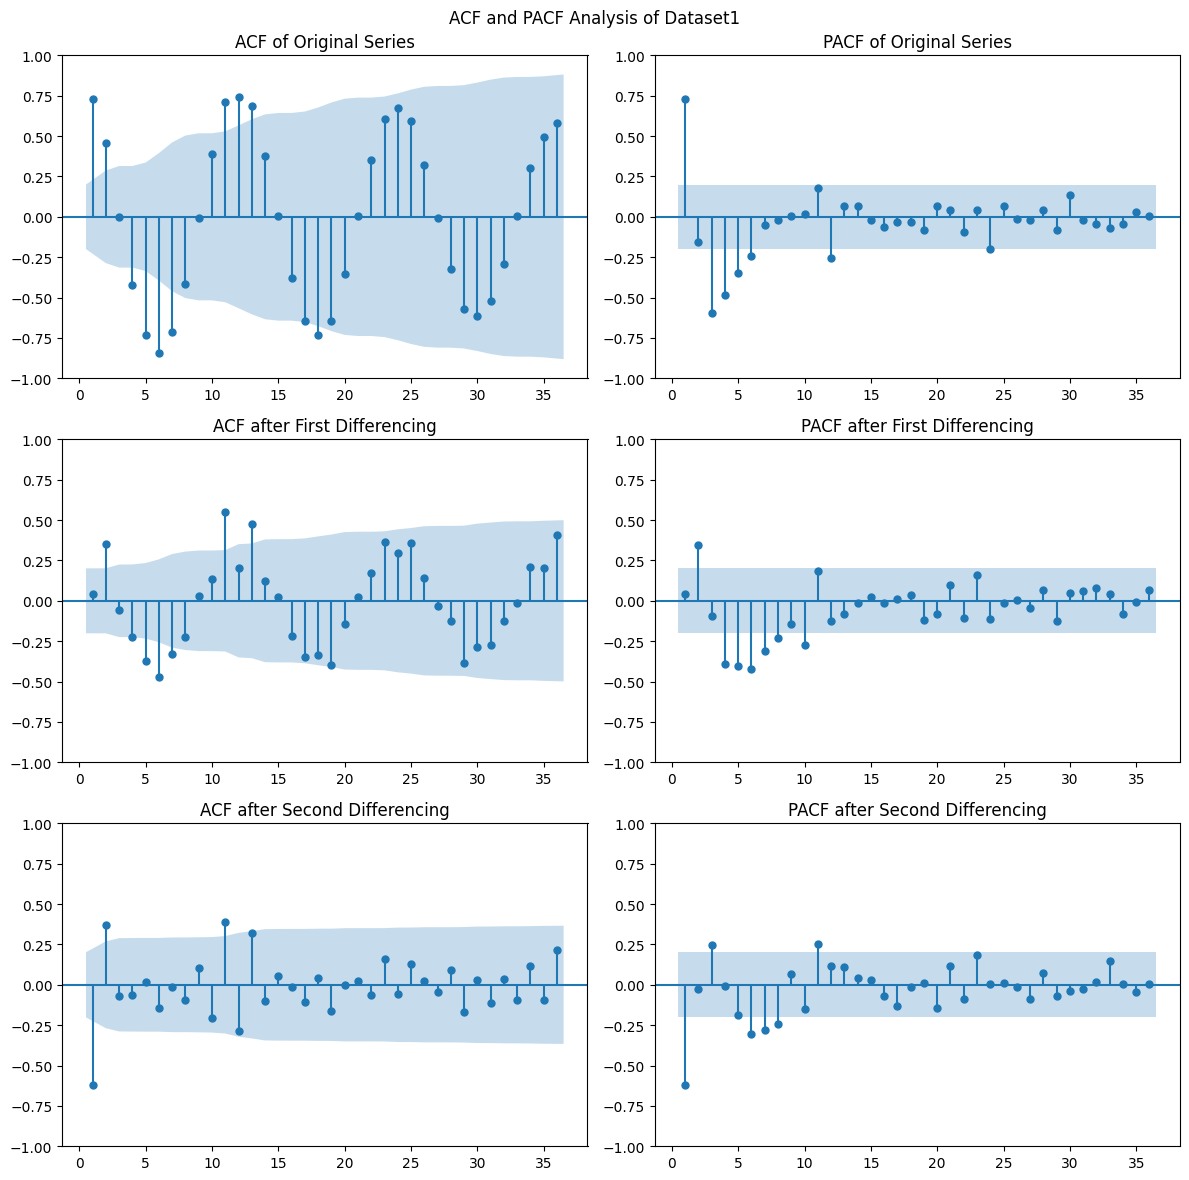

In [82]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Original data plots
plot_acf(df1['y'], lags=36, ax=axes[0, 0], zero=False, title='ACF of Original Series')
plot_pacf(df1['y'], lags=36, ax=axes[0, 1], zero=False, title='PACF of Original Series')

# First difference plots
first_dif = (df1 - df1.shift(1)).dropna()
plot_acf(first_dif['y'], lags=36, ax=axes[1, 0], zero=False, title='ACF after First Differencing')
plot_pacf(first_dif['y'], lags=36, ax=axes[1, 1], zero=False, title='PACF after First Differencing')

# Second difference plots
second_dif = (first_dif - first_dif.shift(1)).dropna()
plot_acf(second_dif['y'], lags=36, ax=axes[2, 0], zero=False, title='ACF after Second Differencing')
plot_pacf(second_dif['y'], lags=36, ax=axes[2, 1], zero=False, title='PACF after Second Differencing')

fig.suptitle('ACF and PACF Analysis of Dataset1', y=0.98)
plt.tight_layout()
plt.show()

Based on these plots, I can determine:

- **d=1**: First differencing removes most trend. Second differencing shows negative lag-1 spike indicating over-differencing.

**Period=12**: ACF of first-difference series shows a significant spike at lag 12. Now let us conduct seasonal differencing for the rest of the paramaters.

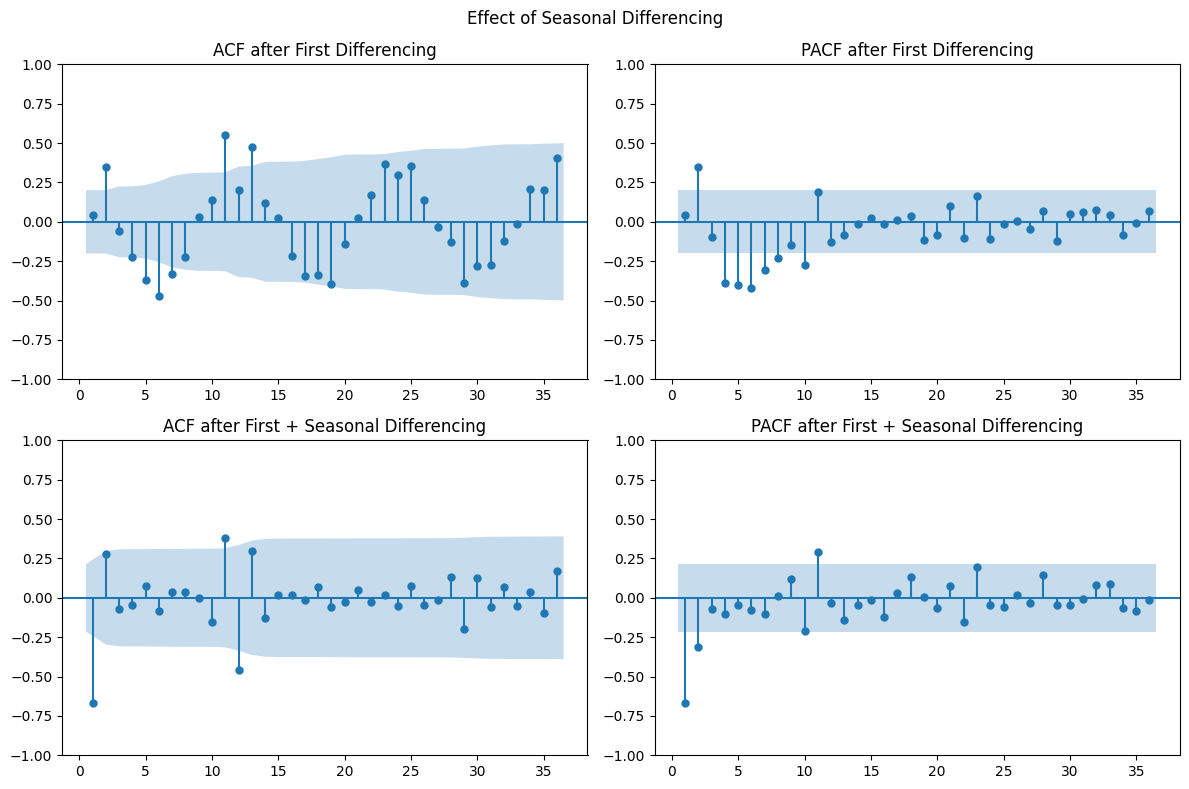

In [83]:
first_dif = (df1 - df1.shift(1)).dropna()

seasonal_dif = (first_dif - first_dif.shift(12)).dropna()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Before
plot_acf(first_dif['y'], lags=36, ax=axes[0, 0], zero=False, 
         title='ACF after First Differencing')
plot_pacf(first_dif['y'], lags=36, ax=axes[0, 1], zero=False, 
          title='PACF after First Differencing')

# After
plot_acf(seasonal_dif['y'], lags=36, ax=axes[1, 0], zero=False, 
         title='ACF after First + Seasonal Differencing')
plot_pacf(seasonal_dif['y'], lags=36, ax=axes[1, 1], zero=False, 
          title='PACF after First + Seasonal Differencing')

plt.suptitle('Effect of Seasonal Differencing', y=0.98)
plt.tight_layout()
plt.show()

- **D=1**: Seasonal differencing is effective due to significant reduction in seasonal spikes at lags 12, 24, and 36 in both ACF and PACF plots. The strong seasonal pattern visible in the first-differenced series is largely eliminated after seasonal differencing.

- **P=1**: The PACF after seasonal differencing shows some remaining structure at seasonal lags, particularly around lag 12, suggesting a seasonal AR(1) component may be appropriate.

- **Q=1**: The ACF after seasonal differencing shows a significant spike around lag 12, indicating a seasonal MA(1) component would help model remaining seasonal effects.

- **p=2**: The PACF of the first-differenced series shows significant spikes at lag 2 followed by a cutoff, indicating an AR(2) process for the non-seasonal component.

- **q=1**: The strong negative spike at lag 1 in the ACF after both differencing operations suggests an MA(1) term would be appropriate.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np

models = [
    # models from previous analysis
    ((1,1,1), (1,1,1,12), "SARIMA(1,1,1)(1,1,1)12"),
    ((2,1,1), (1,1,1,12), "SARIMA(2,1,1)(1,1,1)12"),
    
    # Models without seasonal MA term
    ((1,1,1), (1,1,0,12), "SARIMA(1,1,1)(1,1,0)12"),
    ((2,1,1), (1,1,0,12), "SARIMA(2,1,1)(1,1,0)12"),
    
    # Models without seasonal AR term
    ((1,1,1), (0,1,1,12), "SARIMA(1,1,1)(0,1,1)12"),
    ((2,1,1), (0,1,1,12), "SARIMA(2,1,1)(0,1,1)12"),
    
    # Simpler models
    ((1,1,0), (1,1,0,12), "SARIMA(1,1,0)(1,1,0)12"),
    ((0,1,1), (0,1,1,12), "SARIMA(0,1,1)(0,1,1)12"),
    
]

model_names = []
aic_values = []
bic_values = []
model_params = []
model_se = []
model_pvalues = []
model_convergence = []

for order, seasonal_order, name in models:
    try:
        model = SARIMAX(df1['y'], order=order, seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        
        model_names.append(name)
        aic_values.append(round(result.aic, 3))
        bic_values.append(round(result.bic, 3))
        
        params = result.params
        se = result.bse
        pvalues = result.pvalues
        
        model_params.append(params.to_dict())
        model_se.append(se.to_dict())
        model_pvalues.append(pvalues.to_dict())
        
        # Check for convergence issues
        max_se = se.max()
        model_convergence.append("Issue" if max_se > 10 else "OK")
        
        print(f"Fitted {name}")
    except Exception as e:
        print(f"Error fitting {name}: {e}")
        model_names.append(name)
        aic_values.append(np.nan)
        bic_values.append(np.nan)
        model_params.append({})
        model_se.append({})
        model_pvalues.append({})
        model_convergence.append("Failed")

# Create DataFrame with results
results_df = pd.DataFrame({
    'Model': model_names,
    'AIC': aic_values,
    'BIC': bic_values,
    'Parameters': model_params,
    'Std Errors': model_se,
    'P-values': model_pvalues,
    'Convergence': model_convergence
})

# Sort by AIC
results_df = results_df.sort_values('AIC')

# Display the results
results_df[['Model', 'AIC', 'BIC', 'Convergence']]

Fitted SARIMA(1,1,1)(1,1,1)12
Fitted SARIMA(2,1,1)(1,1,1)12
Fitted SARIMA(1,1,1)(1,1,0)12
Fitted SARIMA(2,1,1)(1,1,0)12


d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fitted SARIMA(1,1,1)(0,1,1)12


d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fitted SARIMA(2,1,1)(0,1,1)12
Fitted SARIMA(1,1,0)(1,1,0)12


d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fitted SARIMA(0,1,1)(0,1,1)12


,Model,AIC,BIC,Convergence
0,"SARIMA(1,1,1)(1,1,1)12",511.883,523.977,Issue
1,"SARIMA(2,1,1)(1,1,1)12",513.034,527.547,Issue
4,"SARIMA(1,1,1)(0,1,1)12",521.733,531.408,Issue
5,"SARIMA(2,1,1)(0,1,1)12",523.636,535.731,Issue
2,"SARIMA(1,1,1)(1,1,0)12",532.669,542.344,OK
3,"SARIMA(2,1,1)(1,1,0)12",534.629,546.723,OK
7,"SARIMA(0,1,1)(0,1,1)12",540.599,547.856,Issue
6,"SARIMA(1,1,0)(1,1,0)12",573.443,580.700,OK


In [88]:
model = SARIMAX(df1['y'], order=(1,1,1), seasonal_order=(1,1,0,12))
results = model.fit(disp=False)

print("SARIMA(1,1,1)(1,1,0)12 Results:")
print("="*50)
print(f"AIC: {results.aic:.3f}")
print(f"BIC: {results.bic:.3f}")
print("\nParameter Estimates:")
print("-"*50)
print(results.summary().tables[1])

SARIMA(1,1,1)(1,1,0)12 Results:
AIC: 532.669
BIC: 542.344

Parameter Estimates:
--------------------------------------------------
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5635      0.095     -5.934      0.000      -0.750      -0.377
ma.L1         -0.9869      0.077    -12.829      0.000      -1.138      -0.836
ar.S.L12      -0.6902      0.083     -8.273      0.000      -0.854      -0.527
sigma2        27.6902      5.658      4.894      0.000      16.600      38.780


# SARIMA(1,1,1)(1,1,0)12 Model Analysis

**Fit Statistics:**
- AIC: 532.669, BIC: 542.344
- All parameters highly significant (p<0.001)

**Parameter Estimates and Interpretation:**
- **AR(1) = -0.5635** (SE: 0.095): The negative coefficient reflects the oscillatory patterns visible in the original time series, where values tend to reverse direction from one month to the next.

- **MA(1) = -0.9869** (SE: 0.077): This near-unity coefficient indicates strong short-term correction effects, aligning with the sharp fluctuations observed in the differenced series.

- **Seasonal AR(1) = -0.6902** (SE: 0.083): Captures the clear yearly seasonality evident in the decomposition plot. The negative coefficient indicates seasonal reversals.

- **d=1, D=1**: The need for both regular and seasonal differencing confirms the non-stationary seasonal components identified in our initial decomposition.

This model effectively captures the minimal upward trend, strong seasonal pattern, and short-term fluctuations that characterize the dataset. The parameter values align with the visual patterns observed in both the original and differenced series.

<Figure size 1200x800 with 0 Axes>

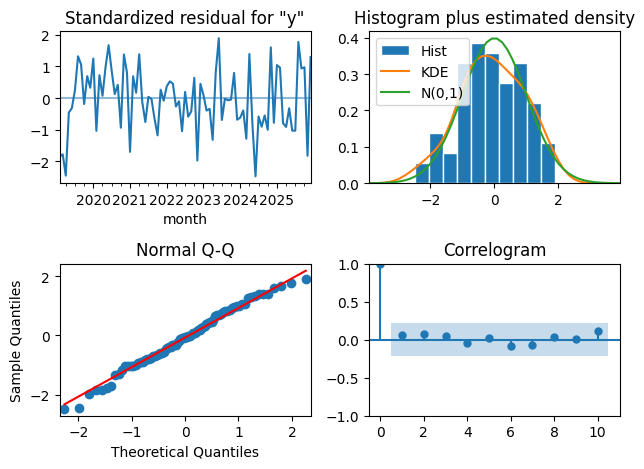

In [89]:
plt.figure(figsize=(12, 8))
results.plot_diagnostics()
plt.tight_layout()
plt.show()

# SARIMA Model Diagnostic Analysis

**Temporal patterns**: Residuals show minor patterns and potential volatility clusters, suggesting possible heteroscedasticity. This might warrant exploring GARCH components to model changing variance if precise prediction intervals are needed.

**Distribution**: The slightly right-skewed residuals deviate from perfect normality, with Q-Q plot confirming minor tail deviations. While this won't significantly impact point forecasts, it could affect prediction interval accuracy, potentially requiring non-Gaussian error distributions if extreme value prediction is critical.

**Autocorrelation**: The correlogram shows no significant autocorrelations at any lag, confirming our SARIMA(1,1,1)(1,1,0)12 specification has successfully captured the primary temporal dependencies in the data.

Overall, these diagnostics indicate a satisfactory model fit for most practical purposes, with refinements only necessary if forecasting precision at extremes is required. The lack of significant autocorrelations is particularly reassuring, suggesting we've correctly specified the ARIMA orders despite the minor distribution and variance issues.